In [35]:
import os
from collections import defaultdict
from tqdm import tqdm
import numpy as np
from src.adjacency_matrix import AdjacencyMatrix
from src.experimenter import get_default_params,perform_link_prediction
from src.data_preparer import filter_size, filter_time
from src.utils import print_matrix, _or, get_printable_matrix, get_base_path
from src.vertex import Vertex
from scipy.sparse import csr_matrix
from joblib import Memory
data_path = get_base_path()
cachedir = os.path.join(data_path, 'cache')
memory = Memory(cachedir, verbose=0)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.sparse import triu, spdiags
import networkx as nx


In [3]:
import sys
sys.path.append('../')
from src.utils import get_data_abbr, mkdir_p, get_base_path, get_library_path

library_path = get_library_path()
sys.path.append(library_path)
sys.path.append(os.path.join(library_path, "hynetworkx"))
from src.data_preparer import filter_size, prepare_lp_data, get_time_filter_params,incidence_to_hyperedges, S_to_A
from src.incidence_matrix import parse_benson_incidence_matrix as parse_S
from collections import Counter


In [28]:
params = get_default_params()
data_name = 'email-Enron'
# data_name = 'contact-high-school'
# data_name = 'NDC-substances'
# data_name = 'tags-math-sx'

iiii=3
params['data_params']['max_size_limit']=10

split_mode = 'structural'
params['data_params']['data_name'] = data_name
params['data_params']['split_mode'] = split_mode
dfs = []
i = 0
params['iter_var'] = 2
data_params = params['data_params']
lp_data_params=params['lp_data_params']
lp_params=params['lp_params']

In [29]:
data_name, base_path, split_mode, max_size_limit = [data_params[x] for x in
                                                        ['data_name', 'base_path', 'split_mode', 'max_size_limit']]
rho, neg_factor, neg_mode = [lp_data_params[x] for x in['rho', 'neg_factor', 'neg_mode']]
S, times, id_label_map = parse_S(data_name,base_path,split_mode,max_size_limit,
                                                       *get_time_filter_params(data_name))
# print(S.shape)

In [11]:
list(sorted(dict(Counter(np.array(S.sum(axis=0)).ravel())).items()))

[(2, 1130),
 (3, 745),
 (4, 535),
 (5, 500),
 (6, 318),
 (7, 335),
 (8, 360),
 (9, 297),
 (10, 305)]

In [96]:
data_names=['email-Enron','contact-high-school','NDC-substances','tags-math-sx','ego-Facebook','flight']
file = open('dict_case'+str(iiii)+'_'+str(10), 'rb')
data = pickle.load(file)
file.close()
dataset_dict={}

for data_name in data_names:
    params['data_params']['data_name'] = data_name
    S, times, id_label_map = parse_S(data_name,base_path,split_mode,max_size_limit,
                                                           *get_time_filter_params(data_name))
    A=S_to_A(S,False)
    G = nx.from_scipy_sparse_matrix(A)
    var=(data_name,'structural')
    n_V = S.shape[0]
    n_E = triu(A).nnz
    n_H = S.shape[1]
    C_C = nx.algorithms.cluster.average_clustering(G)
    Size_D = list(sorted(dict(Counter(np.array(S.sum(axis=0)).ravel())).items()))
    G_D = nx.classes.function.density(G)
    m_cn = data[var]['estimated_mean']
    v_cn = data[var]['estimated_var']
    m_l = data[var]['est_mean_linked']
    v_l = data[var]['est_var_linked']
    m_ul = data[var]['est_mean_unlinked']
    v_ul = data[var]['est_var_unlinked']
    dataset_dict[data_name]={'n_V':n_V,'n_E':n_E,'n_H':n_H,'Size_D':Size_D,'m_cn':m_cn,'v_cn':v_cn,
                            'm_l':m_l,'v_l':v_l,'m_ul':m_ul,'v_ul':v_ul,'C_C':C_C,'G_D':G_D,}

/home2/e1-313-15477/.local/lib/python3.7/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


(217219821220, None)


In [97]:
df_H = pd.DataFrame(dataset_dict).T.reset_index()
df_H

,index,n_V,n_E,n_H,Size_D,m_cn,v_cn,m_l,v_l,m_ul,v_ul,C_C,G_D
0,email-Enron,148,1442,1436,"[(2, 809), (3, 317), (4, 138), (5, 63), (6, 43...",3.52491,26.8183,11.2989,35.6256,2.1043,8.58135,0.520187,0.132561
1,contact-high-school,327,5818,7818,"[(2, 5498), (3, 2091), (4, 222), (5, 7)]",4.52437,50.798,17.6452,86.1718,2.7,14.4178,0.503505,0.109154
2,NDC-substances,5556,26973,4525,"[(2, 1130), (3, 745), (4, 535), (5, 500), (6, ...",0.796547,18.1057,23.7971,676.989,0.12537,1.56512,0.286946,0.00174789
3,tags-math-sx,1554,37955,22274,"[(2, 2417), (3, 7524), (4, 7453), (5, 4880)]",4.88687,126.371,36.2153,1239.05,3.80369,47.1597,0.555467,0.031454
4,ego-Facebook,333,2519,2519,"[(2.0, 2519)]",1.45106,18.8906,12.7908,99.986,0.830329,5.93826,0.508245,0.0455697
5,flight,3330,19079,19079,"[(2.0, 19079)]",0.617343,9.77832,15.8557,305.055,0.16525,1.27664,0.492539,0.00344213


In [12]:
def S_to_A(S, weighted, silent=True):
    if not silent:
        print('Converting S to A')
        print('STEP 1: Computing SS^T')
    A = S * S.T

    if weighted == False:
        if not silent:
            print('STEP 2: Binarizing A')
        A[A > 0] = 1
    if not silent:
        print('STEP 3: Setting diagonals to 0')
    A.setdiag(0)
    if not silent:
        print('STEP 4: Eliminating zeros')
    A.eliminate_zeros()
    return A

[28 21 27 ...  8 12  8]
[13  3 16 ...  2  0  9]
[55 28 13 ...  0  0  0]
[20 22 21 ... 20 22 16]
[1 0 1 ... 1 5 0]
[26 20  1 ...  0  0  0]
[9 7 9 ... 3 2 0]
[0 0 0 ... 0 0 0]
[1 1 1 ... 0 0 0]
[ 58  51 113 ...   2   2   3]
[13 37 56 ...  0  0  0]
[185  58  51 ...   0   0   0]
[15 23 33 ...  0  0  0]
[ 5 14  6 ...  0  0  0]
[36 15 43 ...  0  0  0]
[8 3 5 ... 1 1 0]
[14  0  0 ...  0  0  0]
[18  8 21 ...  0  0  0]
[ 1  1  1 ... 16 35 16]
[ 2  4  7 ... 21  4 36]
[18  1 16 ...  0  0  0]


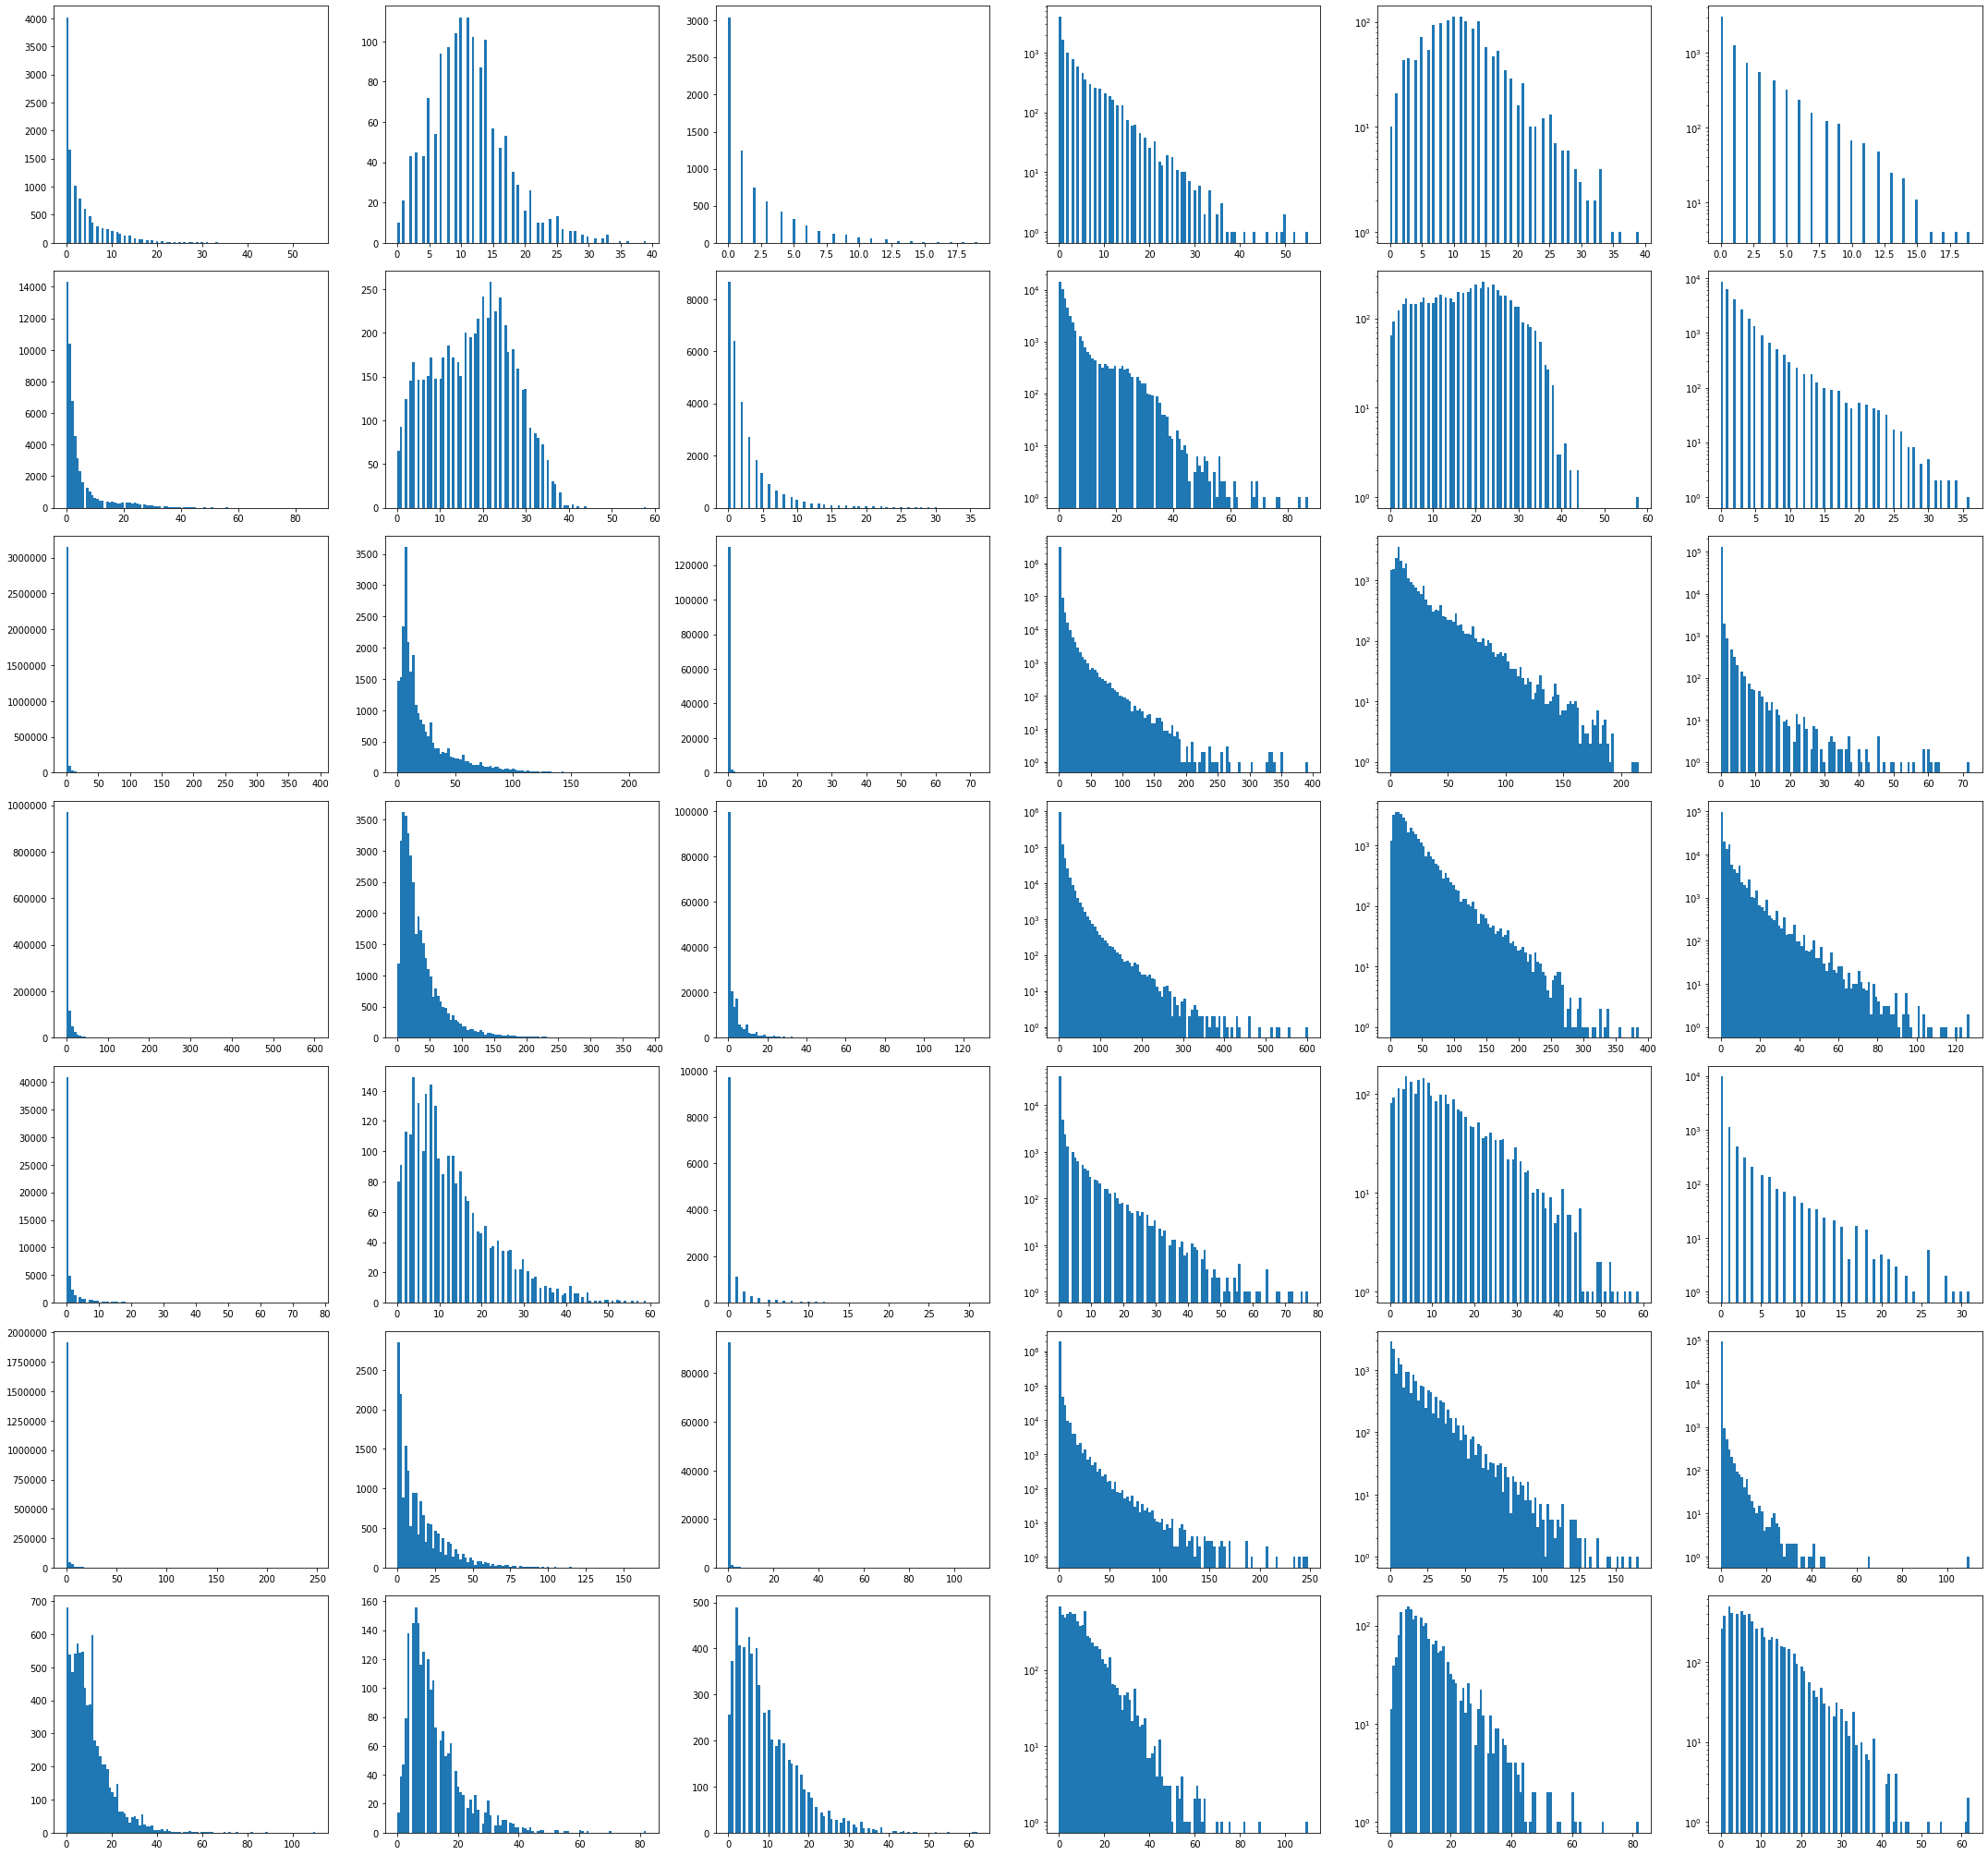

In [145]:
iiii=3
params['data_params']['max_size_limit'] = 10
data_names=['email-Enron','contact-high-school','NDC-substances','tags-math-sx','ego-Facebook','flight','food']
# data_names=['email-Enron','contact-high-school','NDC-substances','tags-math-sx']
params['data_params']['data_name'] = data_names[3]

fig, axs = plt.subplots(len(data_names), 6, figsize = (30, len(data_names)*4))
for i, data_name in enumerate(data_names):
#     data_name = data_names[3]


    file = open(data_name+'_linked_cnd_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'rb')
    data_l = pickle.load(file)
#     print(data_l)
    file.close()

    file = open(data_name+'_unlinked_cnd_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'rb')
    data_ul = pickle.load(file)
#     print(data_ul)
    file.close()

    file = open(data_name+'_cnd_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'rb')
    data_cn = pickle.load(file)
#     print(data_cn)
    file.close()

    ax = axs[i, 0]
    ax.hist(data_cn,bins=100)
#     plt.show()
    ax = axs[i, 1]
    ax.hist(data_l,bins=100)
#     plt.show()
    ax = axs[i, 2]
    ax.hist(data_ul,bins=100)
#     plt.show()
    ax = axs[i, 3]
    ax.hist(data_cn,bins=100, log =True)
#     plt.show()
    ax = axs[i, 4]
    ax.hist(data_l,bins=100, log =True)
#     plt.show()
    ax = axs[i, 5]
    ax.hist(data_ul,bins=100, log =True)
plt.tight_layout()

In [148]:
from sklearn.feature_selection import mutual_info_regression

iiii=3
params['data_params']['max_size_limit'] = 10
data_names=['email-Enron','contact-high-school','NDC-substances','tags-math-sx','ego-Facebook','flight','food']
# data_names=['email-Enron','contact-high-school','NDC-substances','tags-math-sx']
# params['data_params']['data_name'] = data_names[3]

# fig, axs = plt.subplots(len(data_names), 6, figsize = (30, len(data_names)*4))
for i, data_name in enumerate(data_names):
    file = open(data_name+'_linked_cnd_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'rb')
    data_l = pickle.load(file)
    file.close()
    file = open(data_name+'_unlinked_cnd_case'+str(iiii)+'_'+str(params['data_params']['max_size_limit']), 'rb')
    data_ul = pickle.load(file)
    file.close()
    print(len(data_l))
    print(len(data_ul))
    x = data_l
    y = data_ul
    # reshape necessary because the function accepts many
    # features at once to be compared with the right-hand side
    print(mutual_info_regression(x.reshape(-1, 1), y))
    # print(mutual_info_regression(x.reshape(-1, 1), z))

1442
7210


ValueError: Found input variables with inconsistent numbers of samples: [1442, 7210]

In [143]:
df = pd.read_csv('/home2/e1-313-15477/food/food.txt',header=None, skiprows=5,sep=' ')
print(df)
df.to_csv('/home2/e1-313-15477/food/food_native.edges',index=False,header=None,sep=' ')
# df

        0    1
0     125    0
1     125    1
2     125    2
3     125    3
4     125    4
...   ...  ...
2101  119  127
2102  120  127
2103  121  127
2104  122  127
2105  123  127

[2106 rows x 2 columns]


In [132]:
df = pd.read_csv('/home2/e1-313-15477/flight/flight.txt',header=None,) 
df=df.iloc[:, [3,5]]
df.rename(columns = {3:'source',5:'destination'}, inplace = True) 
df = df[~(df['source'] == "\\N") & ~(df['destination'] == "\\N")]
df.to_csv('/home2/e1-313-15477/flight/flight_native.edges',index=False,header=None,sep=' ')
df

,source,destination
0,2965,2990
1,2966,2990
2,2966,2962
3,2968,2990
4,2968,4078
...,...,...
67658,6334,3341
67659,4029,2912
67660,2912,4029
67661,2912,2913
